In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
# no need to use these
#import sys
#sys.path.append("/accounts/campus/aliyahhsu/.local/bin") #/accounts/campus/aliyahhsu/.local/bin

#import sys
#print(sys.path)

In [ ]:
# prepare the env
#!python3.12 -m pip install transformer_lens
#!python3.12 -m pip install --upgrade setuptools
#!python3.12 -m pip install --upgrade packaging
#!python3.12 -m pip install wandb==0.17.2

In [3]:
import argparse
import numpy as np
import os
import sys
import pandas as pd
import scipy as sp
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import math
import tqdm
import itertools

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from sklearn import preprocessing
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification

In [4]:
torch.autograd.set_grad_enabled(False)

# Load data

## Model Args Setup

In [5]:
args = {
    'model_type': 'bert', # bert, medical_bert, pubmed_bert, biobert, clinical_biobert
    'field': 'PrimaryGleason'
}

device = 'cuda:0'

In [6]:
if args['model_type'] == 'bert':
    bert_path = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
elif args['model_type'] == 'medical_bert':
    bert_path = f"{base_dir}/models/pretrained/bert_pretrain_output_all_notes_150000/"
    tokenizer = BertTokenizer.from_pretrained(bert_path, local_files_only=True)
elif args['model_type'] == 'pubmed_bert':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
elif args['model_type'] == 'pubmed_bert_full':
    bert_path = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
elif args['model_type'] == 'biobert':
    bert_path = "dmis-lab/biobert-v1.1"
    tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
elif args['model_type'] == 'clinical_biobert':
    bert_path = "emilyalsentzer/Bio_ClinicalBERT"
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Load data

In [7]:
# Read in data
#field = 'PrimaryGleason' # out of PrimaryGleason, SecondaryGleason', 'MarginStatusNone', 'SeminalVesicleNone'
path = os.path.join(base_dir, "data/prostate.json")
data = readJson(path)

# Clean reports
data = cleanSplit(data, stripChars)
data['dev_test'] = cleanReports(data['dev_test'], stripChars)
data = fixLabel(data)

train_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['train']]
val_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['val']]
test_documents = [extract_synoptic(patient['document'].lower(), tokenizer) for patient in data['test']]
print(len(train_documents), len(val_documents),len(test_documents))

Token indices sequence length is longer than the specified maximum sequence length for this model (1345 > 512). Running this sequence through the model will result in indexing errors
2024-09-13 11:00:01.185194: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 11:00:14.920698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2066 517 324


In [8]:
# Create datasets
train_labels = [patient['labels'][args['field']] for patient in data['train']]
val_labels = [patient['labels'][args['field']] for patient in data['val']]
test_labels = [patient['labels'][args['field']] for patient in data['test']]

train_documents, train_labels = exclude_labels(train_documents, train_labels)
val_documents, val_labels = exclude_labels(val_documents, val_labels)
test_documents, test_labels = exclude_labels(test_documents, test_labels)

le = preprocessing.LabelEncoder()
le.fit(train_labels)

# Map raw label to processed label
le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
le_dict = {str(key):le_dict[key] for key in le_dict}

for label in val_labels + test_labels:
    if str(label) not in le_dict:
        le_dict[str(label)] = len(le_dict)

# Map processed label back to raw label
inv_le_dict = {v: k for k, v in le_dict.items()}

In [9]:
documents_full = train_documents + val_documents + test_documents
labels_full = train_labels + val_labels + test_labels

## Load model

In [10]:
#load finetuned model
model_path = os.path.join(base_dir, "models/path/bert_PrimaryGleason") # /{args['model_type']}_{args['field']}"
checkpoint_file = os.path.join(model_path, "save_output")
# config_file = f"{model_path}/save_output/config.json"

model = BertForSequenceClassification.from_pretrained(checkpoint_file, num_labels=len(le_dict), output_hidden_states=True)

model = model.eval()
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Sanity checks

In [32]:
source_list = [[(0, 0, i) for i in range(12)], [(5, 78, 6)]] #(layer, pos, attn_head)
# target_nodes = [(7, 7, 7)]
# target_nodes = []

text = documents_full[1979]
encoding = get_encoding(text, tokenizer, device)
out_decomps, target_decomps, _, pre_layer_activations = prop_BERT_hh(encoding, model, source_list, target_nodes, device, mean_acts=None, output_att_prob=False, set_irrel_to_mean=False)
# out_decomps_2, target_decomps_2, _, pre_layer_activations = prop_BERT_hh(encoding, model, source_list, target_nodes, device, mean_acts=None, output_att_prob=False, set_irrel_to_mean=False, cached_pre_layer_acts=pre_layer_activations)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11)]
[(5, 78, 6)]
[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11)]
[(5, 78, 6)]


In [33]:
print(out_decomps)
print(out_decomps_2)

[(array([[ 0.25558382, -0.02103147, -0.2327886 ]], dtype=float32), array([[ 5.75832  , -1.4876882, -4.001626 ]], dtype=float32)), (array([[ 0.02751533, -0.00051159, -0.02355184]], dtype=float32), array([[ 5.986387 , -1.5082029, -4.2108665]], dtype=float32))]
[(array([[ 0.25558382, -0.02103147, -0.2327886 ]], dtype=float32), array([[ 5.75832  , -1.4876882, -4.001626 ]], dtype=float32)), (array([[ 0.02751533, -0.00051159, -0.02355184]], dtype=float32), array([[ 5.986387 , -1.5082029, -4.2108665]], dtype=float32))]


In [28]:
print(target_decomps)
print(target_decomps_2)

[[(array([], shape=(0, 64), dtype=float32), array([], shape=(0, 64), dtype=float32)), (array([], shape=(0, 64), dtype=float32), array([], shape=(0, 64), dtype=float32)), (array([], shape=(0, 64), dtype=float32), array([], shape=(0, 64), dtype=float32)), (array([], shape=(0, 64), dtype=float32), array([], shape=(0, 64), dtype=float32)), (array([], shape=(0, 64), dtype=float32), array([], shape=(0, 64), dtype=float32)), (array([], shape=(0, 64), dtype=float32), array([], shape=(0, 64), dtype=float32)), (array([], shape=(0, 64), dtype=float32), array([], shape=(0, 64), dtype=float32)), (array([[ 3.22895497e-03, -1.41495481e-01,  4.12446670e-02,
        -1.39353633e-01,  1.95617545e-02,  4.74978164e-02,
         8.33302587e-02, -9.99630988e-03, -1.37108453e-02,
         1.88778341e-02, -5.66668436e-02, -1.81988683e-02,
         9.38941985e-02, -1.41423792e-01,  0.00000000e+00,
         2.49621663e-02, -7.64959259e-04, -5.92483468e-02,
         1.74365208e-01, -9.65214670e-02, -1.19338088e-

In [12]:
logits = model(encoding['input_ids'], encoding['attention_mask']).logits
logits

tensor([[ 6.0139, -1.5087, -4.2344]], device='cuda:0')

### rel + irrel = total logits

In [46]:
for i in random.sample(range(len(documents_full)), 20):
    text = documents_full[i]
    encoding = get_encoding(text, tokenizer, device)
    logits = model(encoding['input_ids'], encoding['attention_mask']).logits
    
    out_decomps, target_decomps, _ = prop_BERT_hh(encoding, model, source_list, target_nodes, device, mean_acts=None, output_att_prob=False, set_irrel_to_mean=False)
    
    for x in out_decomps:
        try:
            assert(np.mean(np.abs((x[0] + x[1]) - logits.detach().cpu().numpy())[0]) <= 1e-03)
        except:
            print(np.abs((x[0] + x[1]) - logits.detach().cpu().numpy())[0])
            print(i)

### local feature importance

In [13]:
def compute_word_intervals(token_lst):
    word_cnt = 0
    interval_dict = collections.defaultdict(list)

    pretok_sent = ""

    tokens_len = len(token_lst)
    for i in range(tokens_len):
        tok = token_lst[i]
        if tok.startswith("##"):
            interval_dict[word_cnt].append(i)
            pretok_sent += tok[2:]
        else:
            word_cnt += 1
            interval_dict[word_cnt].append(i)
            pretok_sent += " " + tok
    pretok_sent = pretok_sent[1:]
    word_lst = pretok_sent.split(" ")

    assert(len(interval_dict) == len(word_lst))

    return interval_dict, word_lst

def combine_token_scores(interval_dict, scores):
    word_cnt = len(interval_dict)
    new_scores = np.zeros(word_cnt)
    for i in range(word_cnt):
        t_idx_lst = interval_dict[i+1]
        if len(t_idx_lst) == 1:
            new_scores[i] = scores[t_idx_lst[0]]
        else:
            new_scores[i] = np.sum(scores[t_idx_lst[0]:t_idx_lst[-1]+1])
    return new_scores

In [159]:
# CD-T local feature importance
text = documents_full[745]
label = labels_full[745]
encoding = get_encoding(text, tokenizer, device)

scores, irrel_scores = comp_cd_scores_level_skip(model, encoding, label, le_dict, device, level = 0, skip = 1, num_at_time = 64)

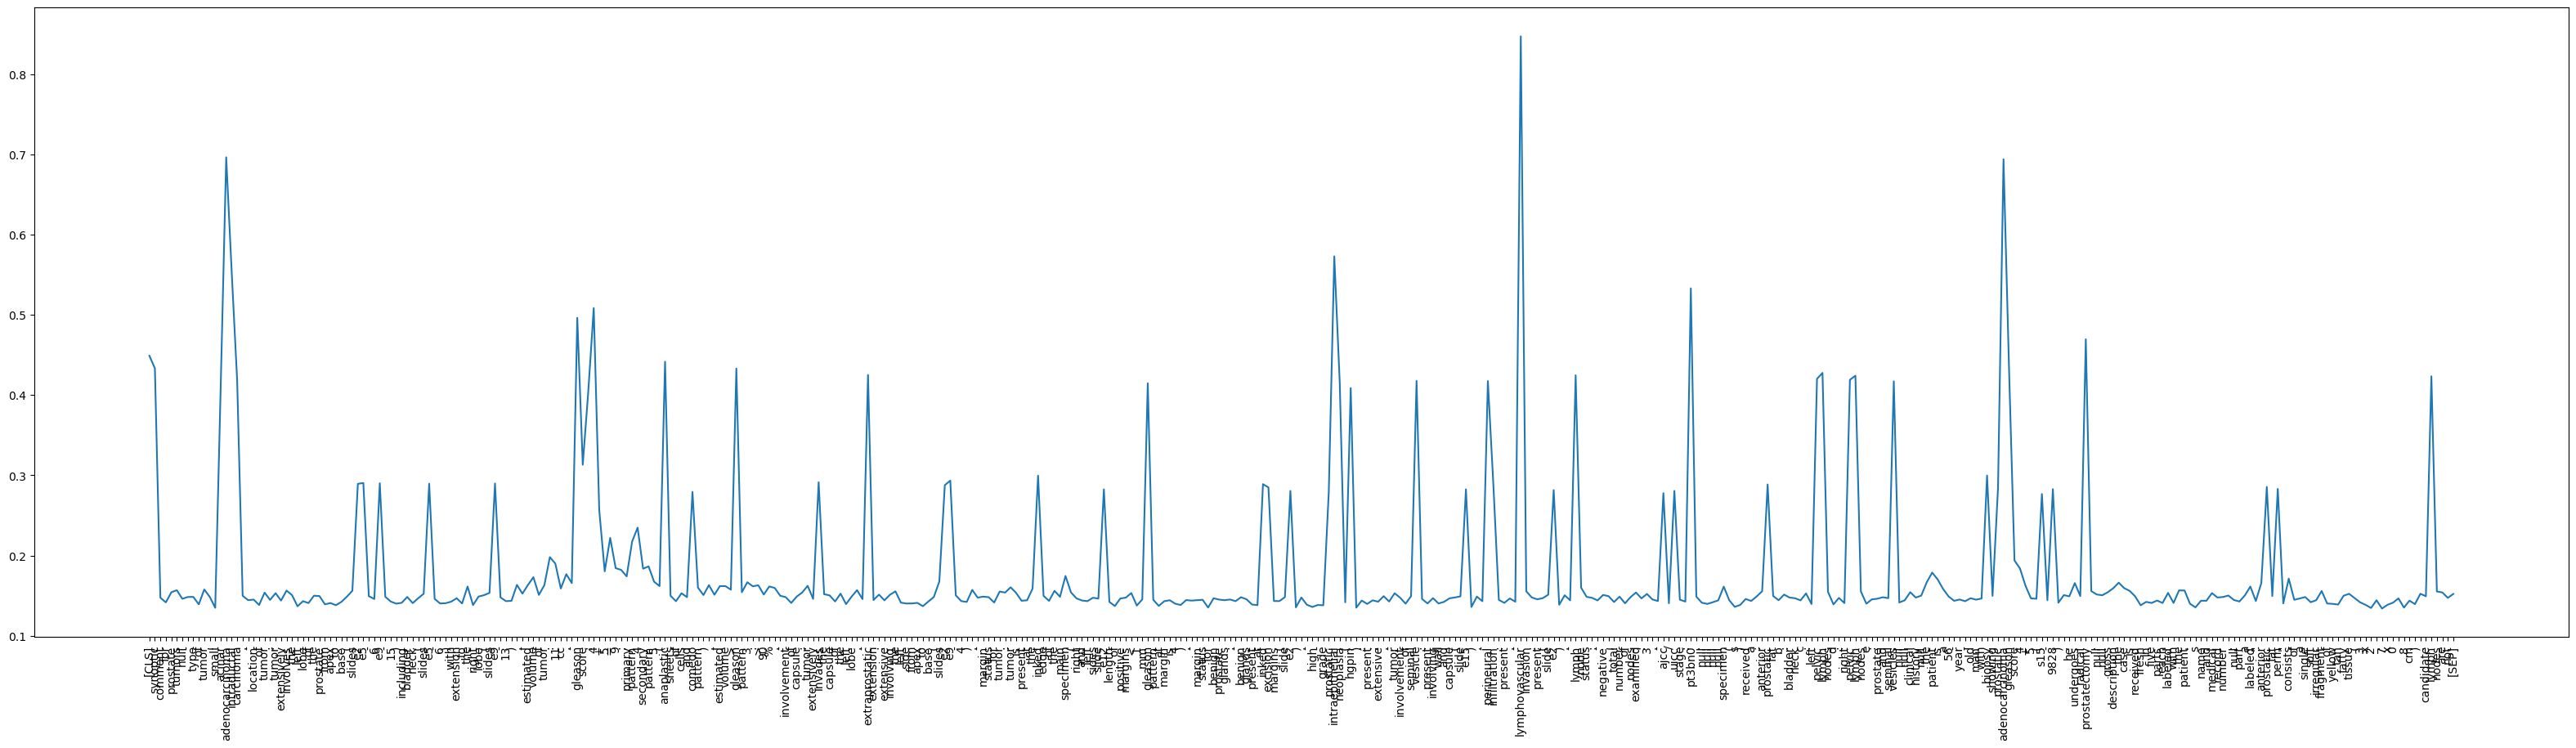

In [160]:
import matplotlib.pyplot as plt

toks = tokenizer.convert_ids_to_tokens([x for x in encoding['input_ids'][0] if x !=0 ])
intervals, words = compute_word_intervals(toks)

word_scores = combine_token_scores(intervals, scores)
irrel_word_scores = combine_token_scores(intervals, irrel_scores) # for ablation purpose

plt.figure(figsize=(40, 10))

x = range(len(words))
y = word_scores
my_xticks = words
plt.xticks(x, my_xticks, rotation=90)
plt.plot(x, y)

In [161]:
ind = np.argpartition(word_scores, -4)[-4:]
np.array(words)[ind]
#words[np.argmax(word_scores)]

array(['intraepithelial', 'adenocarcinoma', 'lymphovascular',
       'adenocarcinoma'], dtype='<U15')

In [162]:
import matplotlib
from IPython.core.display import display, HTML
from matplotlib.colors import LinearSegmentedColormap

def normalize_word_scores(word_scores):
    neg_pos_lst = [i for i, x in enumerate(word_scores) if x < 0]
    abs_word_scores = np.abs(word_scores)
    normalized = (abs_word_scores-min(abs_word_scores))/(max(abs_word_scores)-min(abs_word_scores)) # in [0, 1] range
    for i, x in enumerate(normalized):
        if i in neg_pos_lst:
            normalized[i] = -normalized[i]
    return normalized
            
def chop_cmap_frac(cmap: LinearSegmentedColormap, frac: float) -> LinearSegmentedColormap:
    """Chops off the ending 1- `frac` fraction of a colormap."""
    cmap_as_array = cmap(np.arange(256))
    cmap_as_array = cmap_as_array[:int(frac * len(cmap_as_array))]
    return LinearSegmentedColormap.from_list(cmap.name + f"_frac{frac}", cmap_as_array)

def colorize(words, color_array, mid=0, eps=1e-03):
    cmap_pos = LinearSegmentedColormap.from_list('', ['white', '#48b6df'])
    cmap_neg = LinearSegmentedColormap.from_list('', ['white', '#dd735b'])
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        if color > mid:
          color = matplotlib.colors.rgb2hex(cmap_pos(color)[:3])
        elif color < mid:
          color = matplotlib.colors.rgb2hex(cmap_neg(abs(color))[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [163]:
normalized = normalize_word_scores(word_scores)
irrel_normalized = normalize_word_scores(irrel_word_scores)

In [164]:
s = colorize(words, normalized)
display(HTML(s))

In [165]:
s = colorize(words, irrel_normalized)
display(HTML(s))

In [166]:
s = colorize(words, normalized - irrel_normalized)
display(HTML(s))